# Note Placement Model Test

In [1]:
from sys import platform
from pathlib import Path
import torch
import torch.nn as nn
import torchaudio
from tqdm.auto import tqdm

is_macos = platform == 'darwin'
torch.set_printoptions(sci_mode=False)

In [60]:
class BeatmapConverter:
    def __init__(self,
                audio_dir:Path, 
                osu_dir:Path, 
                data_dir:Path, 
                n_fft_list:list=[1024, 2048, 4096],
                hop_ms:int=10,
                context_window_size = 7):
        self.audio_fns = sorted([p for p in Path(audio_dir).glob('**/*') if p.suffix in {'.mp3', '.wav', '.ogg'}])
        self.osu_fns = sorted(list(Path(osu_dir).rglob('*.osu')))
        self.data_dir = data_dir
        self.melspec_converters = [ torchaudio.transforms.MelSpectrogram(sample_rate=44100,
                                                                        n_fft=n_fft, 
                                                                        hop_length=int(44100*(hop_ms/1000)), 
                                                                        f_max=11000, 
                                                                        n_mels=80,
                                                                        power=2) 
                                                                        for n_fft in n_fft_list ]
        self.context_window_size = context_window_size

    def get_beat_phase(self, note_time, beat_length:float, offset:float):
        return ((note_time - offset) % beat_length) / beat_length

    def parse_beatmap(self, fn):
        # Extract beatmap information from an .osu file.
        # RETURNS: Int: num_keys, FloatTensor: num_notes X 4(time, key_number, note_type, beat_phase).
        #          -1 if error.

        with open(fn, mode='r', encoding='utf-8') as f:
            raw_content = f.read().splitlines()

        timing_points = []
        # Read everything until next section
        i = raw_content.index('[TimingPoints]') + 1
        while raw_content[i] != '' and raw_content[i][0] != '[':
            timing_points.append(raw_content[i])
            i += 1

        # Check if multiple BPMs exist
        beat_lengths = {float(tp.split(',')[1]) for tp in timing_points if float(tp.split(',')[1]) > 0}
        if len(beat_lengths) > 1:
            print(f'Multiple BPMs in file {fn.name}: skipping conversion.')
            return -1, -1

        offset = float(timing_points[0].split(',')[0])
        beat_length = beat_lengths.pop()

        beatmap_start_index = raw_content.index('[HitObjects]')
        beatmap = raw_content[beatmap_start_index + 1:]

        obj_list = []
        xpos_set = set()

        for obj in beatmap:
            obj_split = obj.split(',')
            time = int(obj_split[2])
            xpos = int(obj_split[0])
            xpos_set.add(xpos)

            if obj_split[3] != '1': # If note is long note...
                end_time = int(obj_split[5].split(':', 1)[0])
                obj_list.append([time, xpos, 2, self.get_beat_phase(time, beat_length, offset)])
                obj_list.append([end_time, xpos, 3, self.get_beat_phase(time, beat_length, offset)])
            else:
                obj_list.append([time, xpos, 1, self.get_beat_phase(time, beat_length, offset)])

        xpos_list = sorted(xpos_set)
        xpos2num = {xpos: num for num, xpos in enumerate(xpos_list)}

        obj_list = [[obj[0], xpos2num[obj[1]], obj[2], obj[3]] for obj in obj_list]
        obj_tensor = torch.tensor(obj_list, dtype=torch.float32)

        # Sort by note time in ascending order
        obj_tensor = obj_tensor[obj_tensor[:, 0].argsort()]

        return len(xpos_list), obj_tensor
    
    # def shift_cat_audio(self, y, shift_amount):
    #     tensor_list = []
    #     for shift in range(shift_amount, 0, -1):
    #         shifted = y.

    def convert_audio(self, y):
        # Converts audio into 3-channel mel-spectrogram with context windows.
        # INPUT: waveform of sr=44100
        # OUTPUT: Tensor([num_timesteps, len_window * 2 + 1, 80, 3])

        # Multiple-timescale STFT
        specs = []
        for converter in self.melspec_converters:
            melspec = converter(y)
            specs.append(torch.log(melspec.T))
        specs = torch.stack(specs, dim=-1) # len X 80 X 3
        min_value = torch.min(specs)

        # Shift specs and stack
        shifted_specs = []
        for i in range(self.context_window_size, -self.context_window_size-1, -1):
            shifted = torch.roll(specs, i, 0)
            if i > 0:
                shifted[:i, :, :] = min_value
            elif i < 0:
                shifted[i:, :, :] = min_value
            shifted_specs.append(shifted)
        shifted_specs = torch.stack(shifted_specs, dim=1) # len X 15 X 80 X 3

        return shifted_specs

    def find_file_by_stem(self, fn_list, stem):
        for fn in fn_list:
            if fn.stem == stem:
                return fn
        return -1

    def convert(self, n_fft_list:list=[1024, 2048, 4096], hop_ms:int=10, n_mels:int=80):
        # TODO: include beat phase

        converted_audio_dir = self.data_dir / 'converted_audio/'
        converted_audio_dir.mkdir(exist_ok=True)
        converted_dirs = []

        for osu_fn in tqdm(self.osu_fns):
            # Parse beatmap notes
            num_keys, beatmap = self.parse_beatmap(osu_fn)
            if (num_keys == -1):
                continue

            converted_dir = self.data_dir / f'{num_keys}keys/'
            if converted_dir not in converted_dirs:
                converted_dir.mkdir(exist_ok=True)
                converted_dirs.append(converted_dir)

            # Check if corresponding audio has already been converted
            audio_stem = osu_fn.stem.split('-')[0]
            converted_audio_fn = self.find_file_by_stem(list(converted_audio_dir.glob('*.pt')), audio_stem)

            if converted_audio_fn == -1:
                # Load audio with OS-specific backend
                audio_fn = self.find_file_by_stem(self.audio_fns, audio_stem)
                if audio_fn == -1:
                    print(f'Audio file not found: {audio_stem}')
                    continue

                if is_macos:
                    y, sr = torchaudio.load(audio_fn, backend='ffmpeg')
                else:
                    y, sr = torchaudio.load(audio_fn)

                y = y.mean(dim=0)
                if sr != 44100:
                    print(f'Sampling rate of file {audio_fn.name} is {sr}: Resampling to 44100.')
                    y = torchaudio.functional.resample(y, sr, 44100)

                converted_audio = self.convert_audio(y)

                torch.save({'audio': converted_audio}, (converted_audio_dir / audio_fn.name).with_suffix('.pt'))

            else:
                converted_audio = torch.load(converted_audio_fn)['audio']
        
            torch.save({'audio': converted_audio, 'beatmap': beatmap}, (converted_dir / osu_fn.name).with_suffix('.pt'))

# TODO: define dataset

In [61]:
audio_dir = Path('../osu_dataset/original/')
osu_dir = Path('../osu_dataset/original/')
data_dir = Path('../osu_dataset/')

converter = BeatmapConverter(audio_dir, osu_dir, data_dir)
converter.convert()

  0%|          | 0/261 [00:00<?, ?it/s]

torch.Size([17879, 15, 80, 3])

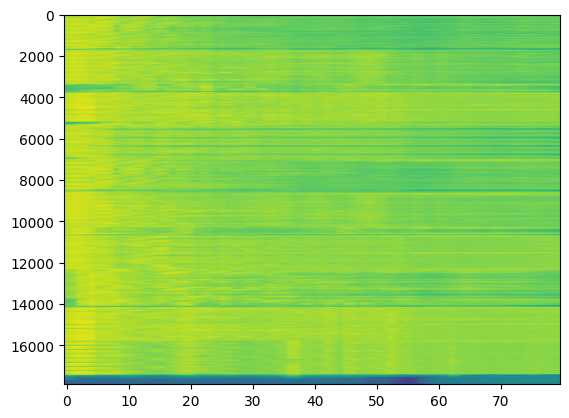

In [35]:
import matplotlib.pyplot as plt

spec1 = spec[:, :, 0]
plt.imshow(spec1, aspect='auto')

In [42]:
torch.load('../osu_dataset/4keys/1019836-189-4.pt')

{'audio': tensor([[[-100.0000, -100.0000,  -95.2671],
          [-100.0000, -100.0000,  -92.9380],
          [-100.0000, -100.0000,  -66.2626],
          ...,
          [-100.0000,  -89.2753,  -81.3982],
          [ -91.9179,  -86.1897,  -79.2755],
          [ -90.5503,  -81.7363,  -78.3457]],
 
         [[-100.0000, -100.0000,  -95.3818],
          [-100.0000, -100.0000,  -89.9957],
          [-100.0000,  -94.2618,  -68.4412],
          ...,
          [ -96.2452,  -87.9964,  -78.4766],
          [ -87.9515,  -82.5127,  -76.0961],
          [ -86.5839,  -80.1687,  -75.0421]],
 
         [[-100.0000,  -99.9394,  -88.9389],
          [ -96.5777,  -97.3742,  -85.9001],
          [ -89.7557,  -87.3100,  -72.2434],
          ...,
          [ -85.5498,  -82.3821,  -76.9738],
          [ -84.3724,  -80.0587,  -76.1759],
          [ -96.4257,  -83.0936,  -76.0197]],
 
         ...,
 
         [[ -66.9830,  -59.5089,  -52.5555],
          [ -63.9295,  -58.2663,  -52.4623],
          [ -63.2848,